In [1]:
import cv2

In [2]:
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
from scipy.fftpack import fft
import math

In [3]:
data, fs = sf.read("dolphinsound.wav")
ch1 = data[:,0]

In [23]:
def removeClick(x):
    thresh = 5
    power = 6
    x = np.array(x*100)
    m = np.mean(x)
    SD = np.std(x)
    w = 1.0/(1+((x-m)/thresh*SD)**power)
    return w*x/100

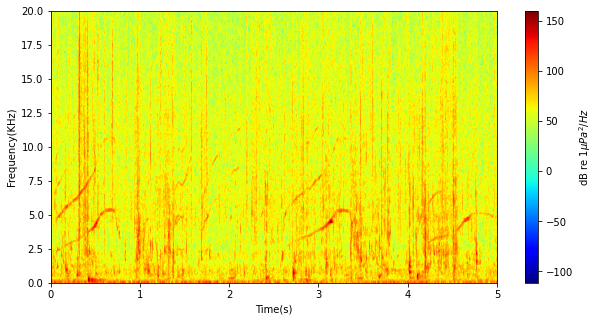

In [29]:
start_time = (6*60+5)
end_time = (6*60+10)
sample_time_series = ch1[fs*start_time:fs*end_time]
PSD = []
sensitivity = 211
hop_size = math.ceil(1024*0.5)
fft_number = 1024
fs = 96000
window = scipy.signal.get_window("hann", fft_number, fftbins=True)
end_index = 1024
while(end_index<len(sample_time_series)):
    windowed_data = window*sample_time_series[end_index-1024:end_index]
    z = fft(windowed_data)[:513]/fft_number*2
    psd = 20*np.log10(abs(z)**2) + sensitivity
    PSD.append(psd)
    end_index += hop_size
PSD = np.array(PSD)

fs = 96000
fig, ax = plt.subplots(figsize=(10,5))
im = ax.imshow(PSD.T, cmap='jet',  origin='lower', aspect='auto',
               interpolation='hanning', extent=(0, 5, 0, fs//2/1000))
ax.set_ylim([0,20])
ax.set_xlabel("Time(s)")
ax.set_ylabel("Frequency(KHz)")
c_bar = fig.colorbar(im)
c_bar.set_label("dB re 1" + r'$\mu Pa^{2}/Hz$')
plt.show()

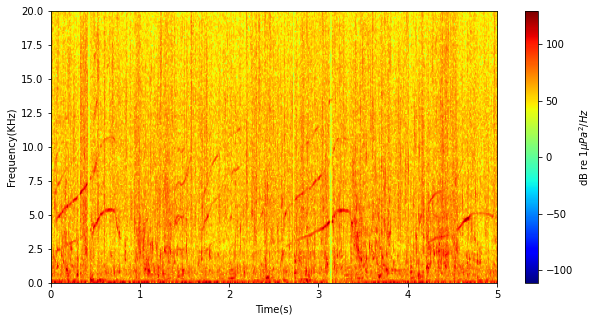

In [30]:
start_time = (6*60+5)
end_time = (6*60+10)
sample_time_series = ch1[fs*start_time:fs*end_time]

PSD_clickRemoval = []

sensitivity = 211
hop_size = math.ceil(1024*0.5)
fft_number = 1024
fs = 96000
window = scipy.signal.get_window("hann", fft_number, fftbins=True)
end_index = 1024
while(end_index<len(sample_time_series)):
    weight_sample = removeClick(sample_time_series[end_index-1024:end_index])
    windowed_data = window*weight_sample
    z = fft(windowed_data)[:513]/fft_number*2
    psd = 20*np.log10(abs(z)**2) + sensitivity
    PSD_clickRemoval.append(psd)
    end_index += hop_size
PSD_clickRemoval = np.array(PSD_clickRemoval)

fs = 96000
fig, ax = plt.subplots(figsize=(10,5))
im = ax.imshow(PSD_clickRemoval.T, cmap='jet',  origin='lower', aspect='auto', 
               interpolation='hanning', extent=(0, 5, 0, fs//2/1000))
ax.set_ylim([0,20])
ax.set_xlabel("Time(s)")
ax.set_ylabel("Frequency(KHz)")
c_bar = fig.colorbar(im)
c_bar.set_label("dB re 1" + r'$\mu Pa^{2}/Hz$')
plt.show()

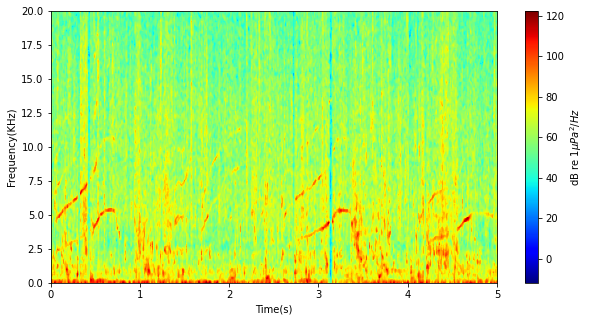

In [31]:
fs = 96000
fig, ax = plt.subplots(figsize=(10,5))
# averageBlur = cv2.blur(PSD_clickRemoval, ksize=(3,3))
# gaussianBlur = cv2.GaussianBlur(PSD, (3, 3), cv2.BORDER_DEFAULT)
medianblur = cv2.medianBlur(PSD_clickRemoval.astype(np.float32),3)
im = ax.imshow(medianblur.T, cmap='jet',  origin='lower', aspect='auto',
               interpolation='hanning', extent=(0, 5, 0, fs//2/1000))
ax.set_ylim([0,20])
ax.set_xlabel("Time(s)")
ax.set_ylabel("Frequency(KHz)")
c_bar = fig.colorbar(im)
c_bar.set_label("dB re 1" + r'$\mu Pa^{2}/Hz$')
plt.show()

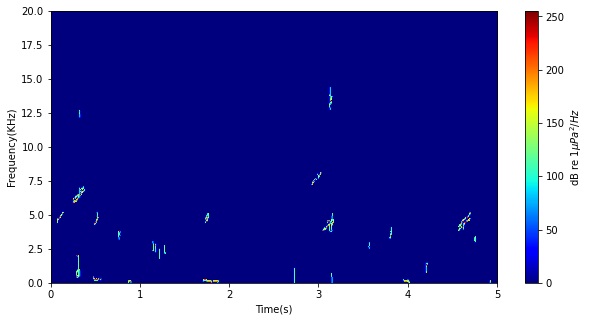

In [38]:
edges = cv2.Canny(medianblur.astype(np.uint8),100,200)
fig, ax = plt.subplots(figsize=(10,5))
im = ax.imshow(edges.T, cmap='jet',  origin='lower', aspect='auto',
               interpolation='hanning', extent=(0, 5, 0, fs//2/1000))

ax.set_ylim([0,20])
ax.set_xlabel("Time(s)")
ax.set_ylabel("Frequency(KHz)")
c_bar = fig.colorbar(im)
c_bar.set_label("dB re 1" + r'$\mu Pa^{2}/Hz$')
plt.show()

In [41]:
np.save("medianBluredSample", medianblur)